In [229]:
%matplotlib inline
import os
import collections
import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook')

# Empirical fitness landscape: Franke et al. 2011

The fitness landscape is composed of 8 loci and 186 combinations of mutations in these loci that were viable and had measurable fitness. Species - [_Aspergillus niger_](http://en.wikipedia.org/wiki/Aspergillus_niger).

## Read fitness landscape file
The [fitness landscape file](https://gitlab.com/yoavram/EvolRugAdaptLand2016/blob/master/Franke2011.csv) was downloaded from [Franke et al. 2011](http://www.ploscompbiol.org/article/info%3Adoi%2F10.1371%2Fjournal.pcbi.1002134) and converted to CSV using [Tabula](http://tabula.nerdpower.org/).

Start by downloading it if it's not already on the local filesystem.

In [2]:
landscape_filename = 'Franke2011.csv'
if not os.path.exists(landscape_filename):
    import urllib.request
    urllib.request.urlretrieve('https://gitlab.com/yoavram/EvolRugAdaptLand2016/raw/master/Franke2011.csv', landscape_filename)

In [3]:
!head $landscape_filename

Mutation number,fwn,arg,pyr,leu,phe,lys,oli,crn,Relative W
0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0.751
1,0,1,0,0,0,0,0,0,0.773
1,0,0,1,0,0,0,0,0,0.698
1,0,0,0,1,0,0,0,0,0.757
1,0,0,0,0,1,0,0,0,0.826
1,0,0,0,0,0,1,0,0,m
1,0,0,0,0,0,0,1,0,0.598
1,0,0,0,0,0,0,0,1,0.628


Read the file using Pandas, and convert `m` values in the `Relative W` column (fitness) to 0, as they mean "missing".

In [4]:
data = pd.read_csv('Franke2011.csv')
missing_W = data['Relative W'] == 'm'
data.loc[missing_W, 'Relative W'] = 0
data['Relative W'] = data['Relative W'].astype(float)
data.head()

,Mutation number,fwn,arg,pyr,leu,phe,lys,oli,crn,Relative W
0,0,0,0,0,0,0,0,0,0,1.000
1,1,1,0,0,0,0,0,0,0,0.751
2,1,0,1,0,0,0,0,0,0,0.773
3,1,0,0,1,0,0,0,0,0,0.698
4,1,0,0,0,1,0,0,0,0,0.757


Create a new column called `genotype` with the bit string of each genotype.

In [5]:
gene_columns = 'fwn 	arg 	pyr 	leu 	phe 	lys 	oli 	crn'.split() # as copied from the table above
data['genotype'] = data[gene_columns].apply(
    lambda row: str.join('', map(str, row)), axis=1)
data.head()

,Mutation number,fwn,arg,pyr,leu,phe,lys,oli,crn,Relative W,genotype
0,0,0,0,0,0,0,0,0,0,1.000,00000000
1,1,1,0,0,0,0,0,0,0,0.751,10000000
2,1,0,1,0,0,0,0,0,0,0.773,01000000
3,1,0,0,1,0,0,0,0,0,0.698,00100000
4,1,0,0,0,1,0,0,0,0,0.757,00010000


In [6]:
fitness = collections.defaultdict(float)
for i, row in data.iterrows():
    fitness[row['genotype']] = row['Relative W']

assert fitness['00000000'] == 1

genotypes = tuple(fitness.keys())
assert '00000000' in genotypes

Define the `hamming` function for distance between genotypes:

In [186]:
def hamming(g1, g2='00000000'):
    assert len(g1) == len(g2)
    return sum(g1i != g2i for g1i, g2i in zip(g1, g2))

assert hamming('00000000', '10000000') == 1
assert hamming('00000000', '10001010') == 3

def plot_matrix(M):
    plt.imshow(M, norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)

## Simulation
Simple deterministic simulation - only single mutations, uniform bi-directional mutation rate, selection determined by the fitness landscape.

In [8]:
n = len(next(iter(fitness)))
mu = 1e-4 # mutation rate as in Szendro et al. 2013 
m = len(genotypes)

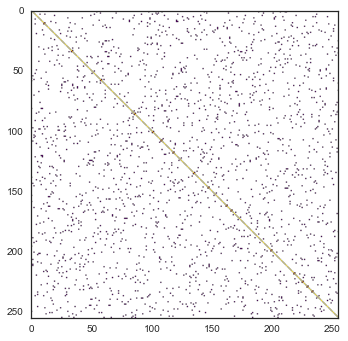

In [9]:
M = np.diag([1.0] * m)
for i in range(m):
    for j in range(m):    
        if hamming(genotypes[i], genotypes[j]) == 1:
            M[j, i] = mu
            M[i, i] -= mu

assert np.allclose(M.sum(axis=1), 1)
plot_matrix(M)

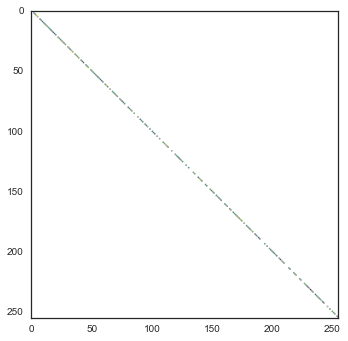

In [10]:
S = np.diag([fitness[g] for g in genotypes])
plot_matrix(S)

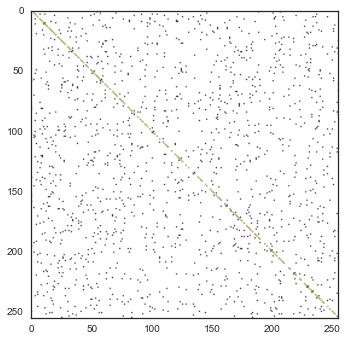

In [11]:
E = M.dot(S)
assert E.shape == (m ,m)
plot_matrix(E)

## Adaptation

Start from a maladapted genotype `11011111` and evolve until 99% of population is fully adapted (fitness = 1).

In [114]:
N = 1e9
generations = 2**15

def adaptation(verbose=True):    
    g0i = genotypes.index('11011111') # index of starting point. 11011111 is also used in Szendro2013
    if verbose:
        print("starting genotype:", genotypes[g0i])
        print("starting fitness:", fitness[genotypes[g0i]])
    g1i = genotypes.index('00000000') # index of most adapted genotype
    
    # p is the frequencies vector
    p = np.empty((m, generations), dtype=float)
    p[:, 0] = 0
    p[g0i, 0] = 1.0
    
    # pom holds the index of the most frequent genotype at each time point
    pom = [p[:, 0].argmax()]
    
    # W holds the population mean fitness at each time point
    W = np.empty(generations, dtype=float)
    W[0] = S.diagonal() @ p[:, 0]  # mean fitness calculation

    for k in range(1, generations):
        if verbose and k % (generations / 10) == 0: 
            print(k, end=" ")
        p[:, k] = E @ p[:, k - 1]  # selection and mutation are deterministic
        p[:, k] /= p[:, k].sum()  # normalize frequencies vector
        p[:, k] = np.random.multinomial(N, p[:, k]) / N  # random genetic drift is stochastic

        W[k] = (S.diagonal().dot(p[:, k]))  # mean fitness calculation
        
        # update pom if most frequent changed
        if p[:, k].argmax() != pom[-1]:     
            pom.append(p[:, k].argmax())
        
        # break if reached fixation
        if p[g1i, k] > 0.99:
            break
    return k, p, W, pom

k, p, W, pom = adaptation(True)
print("# generations:", k)

starting genotype: 11011111
starting fitness: 0.456
# generations: 665


In [141]:
print([gi for gi in pom])
print( [genotypes[gi] for gi in pom])
print( [sum(map(int, genotypes[gi])) for gi in pom])
print( [fitness[genotypes[gi]] for gi in pom])

[32, 22, 88, 111]
['11011111', '11011101', '00001101', '00000000']
[7, 6, 3, 0]
[0.456, 0.841, 0.928, 1.0]


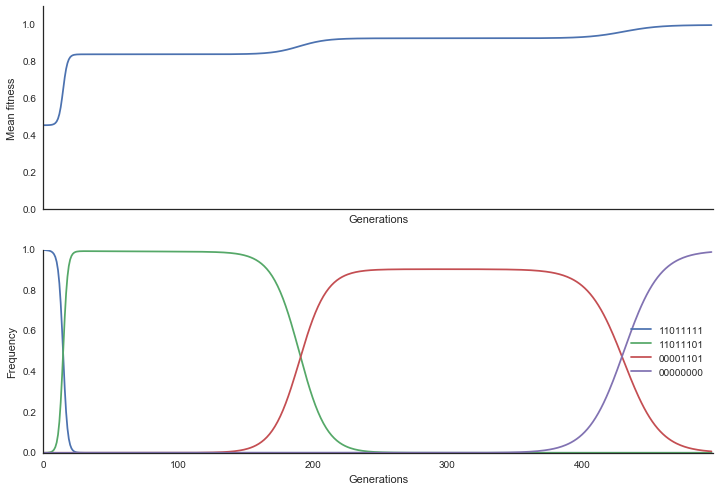

In [157]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].plot(W[:k])
ax[0].set(xlabel='Generations', ylabel='Mean fitness', ylim=(0, 1.1), xlim=(0, k))

ax[1].plot(p[pom, :k].T)
ax[1].set(xlabel='Generations', ylabel='Frequency')
ax[1].legend([genotypes[x] for x in pom], loc='center right')

sns.despine()

#### Creating the LOD

In [156]:
k, p, W, pom = res

In [158]:
def build_lod(p):
    t = k - 1
    lod = np.empty(k, dtype=int)
    lod[t] = p[:, t].argmax() # start with most frequent
    while t > 0:
        gi = lod[t]
        assert S.diagonal()[gi] > 0
        t -= 1
        #q = p[:, t] @ E  # backward mutation and selection
        #q = np.array([fj * M[gi, gj] * S.diagonal()[gj] for gj, fj in enumerate(p[:,t])]) # TODO more efficient
        q = p[:, t] * M[gi, :] * S.diagonal()        
        assert q.sum() > 0, gi
        q /= q.sum()  # normalize frequency vector
        assert (q[S.diagonal() == 0] == 0).all(), q[S.diagonal() == 0]
        gj = np.random.multinomial(1, q).argmax()  # draw a single parent & find its genotype index
        assert S.diagonal()[gj] > 0
        lod[t] = gj
    return lod

lod = build_lod(p)

In [16]:
%load_ext Cython

In [17]:
%%cython
import numpy as np
cimport numpy as np

def clean_lod(np.ndarray[int] lod):
    cdef np.ndarray[char] take = np.ones_like(lod, dtype=np.uint8)
    cdef int i = 1
    cdef int n = len(lod)
    
    for i in range(1, n):
        if lod[i] == lod[i - 1]:
            take[i] = 0

    return lod[take.view(dtype=np.bool)]

In [153]:
cleaned_lod = clean_lod(lod)
clean_lod(lod)

array([ 32,  22,  96, 112,  88, 232, 170, 111])

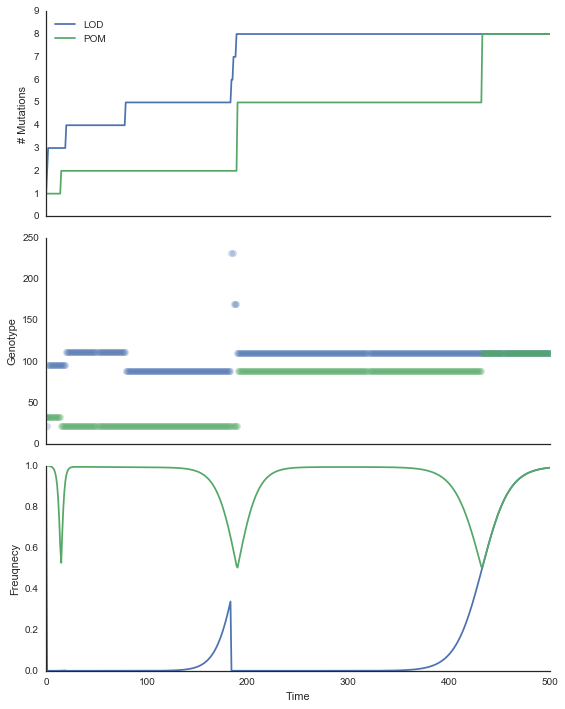

In [154]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

ax[0].plot([n - sum(map(int, genotypes[x])) for x in lod], label='LOD')
ax[0].plot([n - sum(map(int, genotypes[x])) for x in p[:,:k].argmax(axis=0)], label='POM')
ax[0].set(ylabel='# Mutations', ylim=(0, n+1))
ax[0].legend(loc='upper left')

ax[1].plot(lod, 'o', alpha=0.25, label='LOD')
ax[1].plot(p[:,:k].argmax(axis=0), 'o', alpha=0.25, label='POM')
ax[1].set(ylabel='Genotype')

ax[2].plot([p[lod[t], t] for t in range(k)])
ax[2].plot(p[:,:k].max(axis=0))
ax[2].set(xlabel='Time', ylabel='Freuqnecy')

fig.tight_layout()
sns.despine()

### Peaks

In [21]:
def flip_bit(bs, i):
    return '{:08b}'.format(int(bs, base=2) ^ 2**i)

assert flip_bit('10111110', 0) == '10111111'
assert flip_bit('10111110', 1) == '10111100'
assert flip_bit('00111110', 3) == '00110110'

In [22]:
peaks = collections.OrderedDict(fitness)
for g in genotypes:
    for i in range(len(g)):
        g2 = flip_bit(g, i)
        if fitness[g2] > fitness[g]:
            peaks.pop(g)
            break
peak_distances = [sum(map(int, p)) for p in peaks]
print("Number of peaks:", len(peaks))

Number of peaks: 15


### Valleys

In [23]:
valleys = collections.OrderedDict(fitness)
for g in genotypes:
    for i in range(len(g)):
        g2 = flip_bit(g, i)        
        if fitness[g2] and fitness[g2] < fitness[g]:
            valleys.pop(g)
            break

valley_distances = [sum(map(int, p)) for p in valleys]
print( "Number of valleys:", len(valleys))

Number of valleys: 84


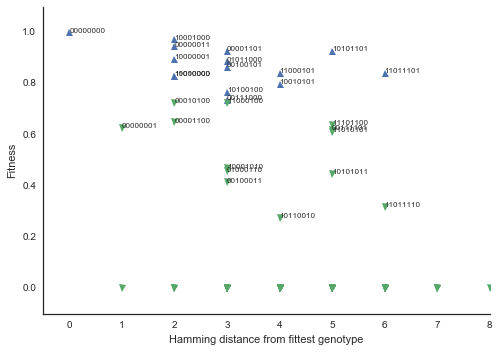

In [24]:
plt.plot(peak_distances, tuple(peaks.values()), '^')
for x,y,z in zip(peak_distances, list(peaks.values()), list(peaks.keys())):
    plt.text(x, y, z, fontsize=8)
    
plt.plot(valley_distances, tuple(valleys.values()), 'v')
for x,y,z in zip(valley_distances, list(valleys.values()), list(valleys.keys())):
    if y > 0:
        plt.text(x, y, z, fontsize=8)
plt.xlim((-0.5, n))
plt.ylim(-0.1, 1.1)
plt.xlabel("Hamming distance from fittest genotype")
plt.ylabel("Fitness");
sns.despine()

## Landscape simulation plot

Perparations - runs 100 simulations to get some data on frequent trajectories.

In [184]:
repetitions = 1000
results = (adaptation(verbose=False) for _ in range(repetitions))

In [185]:
lods = [None] * repetitions
cleaned_lods = [None] * repetitions
for i, (k, p, W, pom ) in enumerate(results):    
    lods[i] = build_lod(p)
    cleaned_lods[i] = clean_lod(lods[i])

In [187]:
genotype_freq = np.zeros(m)

for lod in lods:
    for gi in lod:
        genotype_freq[gi] += 1

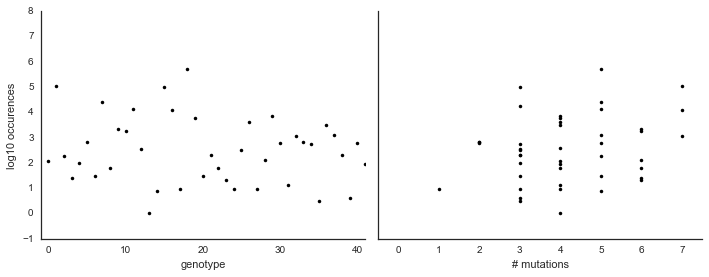

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))

ax1.plot(
    np.log10(genotype_freq[genotype_freq > 0]), 
    '.k'
)
ax1.set_xlabel('genotype')
ax1.set_ylabel('log10 occurences')
ax1.set_xlim(-1,41)
ax1.set_ylim(-1,8)

ax2.plot(
    [hamming(genotypes[gi]) for gi, _ in enumerate(genotype_freq[genotype_freq > 0])], 
    np.log10(genotype_freq[genotype_freq > 0]), 
    '.k')

ax2.set_xlabel('# mutations')
ax2.set_xlim(-0.5,7.5)

fig.tight_layout()
sns.despine()

In [189]:
genotype_freq = {genotypes[gi]:c for gi, c in enumerate(genotype_freq)}

In [191]:
lods_freq = collections.defaultdict(int)
for lod in cleaned_lods:
    lods_freq[tuple(lod)] += 1

top_lods_freq = sorted(lods_freq.items(), key=lambda x: x[1], reverse=True)[:5]
for lod, cnt in top_lods_freq:
    print(lod, cnt / repetitions)

(32, 22, 96, 36, 245, 5, 170, 111) 0.176
(32, 22, 96, 112, 88, 33, 17, 111) 0.098
(32, 22, 96, 36, 245, 5, 208, 111) 0.094
(32, 22, 96, 112, 88, 232, 170, 111) 0.086
(32, 22, 209, 36, 245, 5, 170, 111) 0.039


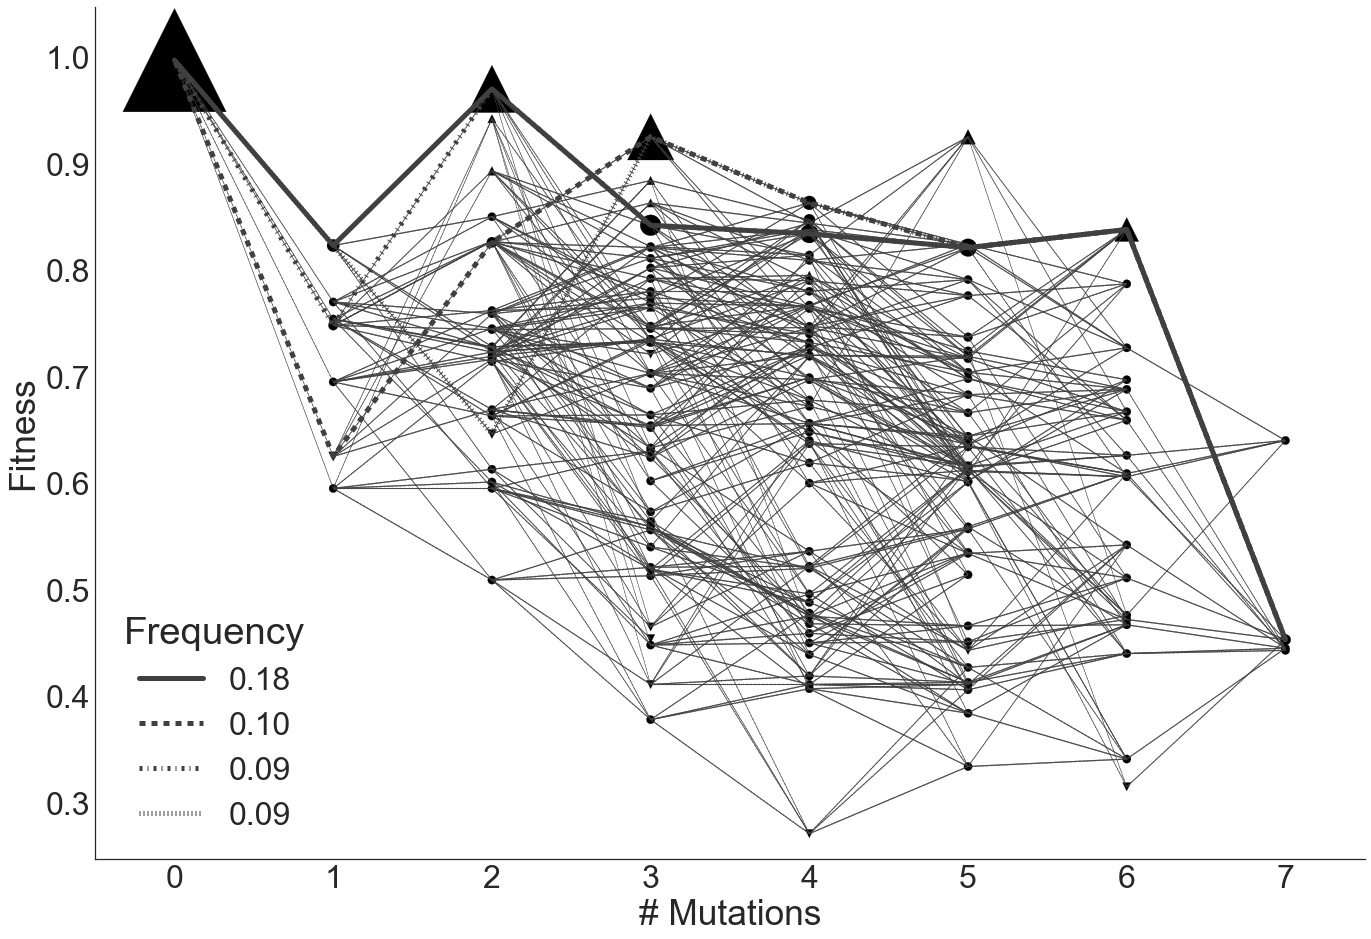

In [260]:
sns.set_context('paper', font_scale=4)

linestyles = 'solid dashed dashdot dotted'.split()

# most frequent LOD
for lod, count in top_lods_freq[:len(linestyles)]:
    linestyle = linestyles.pop(0)
    plt.plot(
        [hamming(genotypes[gi]) for gi in lod], 
        [fitness[genotypes[gi]] for gi in lod], 
        linewidth=5, 
        color='#404040', 
        linestyle=linestyle,
        label='{:.2f}'.format(count / repetitions)
    )

# markers for genotypes
size = lambda g: 70 + 20*genotype_freq[g] / repetitions
plt.scatter(
    [hamming(g) for g, w in fitness.items() if w and g not in peaks and g not in valleys], 
    [w for g, w in fitness.items() if w and g not in peaks and g not in valleys], 
    c='k', 
    marker='o', 
    s=[size(g) for g, w in fitness.items() if w and g not in peaks and g not in valleys]
)
plt.scatter(
    [hamming(g) for g, w in fitness.items() if w and g in peaks], 
    [w for g, w in fitness.items() if w and g in peaks], 
    c='k', 
    marker='^', 
    s=[size(g) for g, w in fitness.items() if w and g in peaks]
)
plt.scatter(
    [hamming(g) for g, w in fitness.items() if w and g in valleys], 
    [w for g, w in fitness.items() if w and g in valleys], 
    c='k', 
    marker='v', 
    s=[size(g) for g, w in fitness.items() if w and g in valleys]
)

# lines for mutations
for g, w in ((g, w) for g, w in fitness.items() if w ):    
    for i in range(len(g)):
        g2 = flip_bit(g, i)
        if fitness[g2] > 0:
            plt.arrow(
                hamming(g), 
                fitness[g], 
                hamming(g2) - hamming(g), 
                fitness[g2] - fitness[g], 
                width=0.001,
                head_width=0,
                color='#404040', 
                alpha=0.75, 
                linestyle='dotted'
            )
    

plt.ylim((0.25, 1.05))
plt.xlim((-0.5, 7.5))
plt.xlabel("# Mutations")
plt.ylabel("Fitness")
plt.legend(title="Frequency", loc='lower left')

fig = plt.gcf()
fig.set_figheight(14)
fig.set_figwidth(20)
fig.tight_layout()
sns.despine()

fig.savefig('fitness_landscape.png')
fig.savefig('fitness_landscape.pdf', dpi=300, papertype='a4')

### Figure caption
**Empirical fitness landscape** - The figure shows the fitness (y-axis) and number of mutations away from the fittest phenotype (x-axis) of 186 genotypes of the filamentous fungus _Aspergillus niger_ from a study by Franke et al. (2011). 
Genotypes were constructed from a combination of 8 single mutants (including both metabolic and resistance genes).
Triangles denote fitness maxima (&#9650;) and minima (&#9660;); 
other genotypes are denoted by circles (&#9679;); 
thin dotted lines connect genotypes that differ by a single mutation.
The wide solid and dashed lines represent the two most common evolutionary trajectories in our simulations;
marker intensities are relative the their frequency in the simulations. 
Parameters: 10<sup>-4</sup> mutations per gene per generation; 10<sup>9</sup> individuals; 2<sup>15</sup> generations.

In [ ]:
print ('mu = 1e', np.log10(mu), 'N = 1e', np.log10(N), 'generations = 2^', np.log2(generations))